<a href="https://colab.research.google.com/github/bamlakm/intro_python/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll first install neuron as usual.

In [1]:
%pip install neuron # only need to run this cell once to install 
                    # neuron in the local jupyter environment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 75.9 MB/s eta 0:00:00


Run the code block below to mount the google drive folder with the rest of the model files. Save your files in a folder in your main google drive folder and set `drive_folder_name` equal to it as a string. It also compiles the mod files in the `mechanisms` folder

In [2]:
drive_folder_name = 'final_project_starter_code'
if 'google.colab' in str(get_ipython()):
    import os
    from google.colab import drive
    drive.mount('/content/drive/')
    os.chdir('/content/drive/MyDrive/' + drive_folder_name)
    # Should now be inside drive folder

!nrnivmodl mechanisms

Mounted at /content/drive/
/content/drive/MyDrive/final_project_starter_code
Mod files: "mechanisms/mechanisms/kv.mod" "mechanisms/mechanisms/na.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Now we can import the packages we'll be using

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary 
import numpy as np
import matplotlib.pyplot as plt

# from exercise 10 pt. 1
import matplotlib as mpl 
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import plotly
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()

Create the Ball and Stick neuron model

In [4]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.6 # 0 to 1, if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
cell = BallAndStick(0,ais_mode, ais_loc)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)

# Simulation parameter settings
h.celsius = 37
h.steps_per_ms = 1/0.025
h.dt = 0.025
h.tstop = 20
h.v_init = -69

# Stimulation
iclamp = h.IClamp(cell.soma(0.5))
iclamp.delay = 5
iclamp.dur = 5
iclamp.amp = 1
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
                                                                                                                                `--------------------|       BallAndStick[0].ais_prox(0-1)
                                                                                                                                                      `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                                                                                                                                            `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|      

Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma. (see Exercise 9 for detail instructions on how to make synapses)

In [5]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.8 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
exc_syn = h.Exp2Syn(cell.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # rise time - taken from Hodapp 2022 supp materials
exc_syn.tau2 = 5 # decay time
exc_syn.e = 0 # reversal (more permeable to sodium than potassium)

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell.soma(0.5))
inh_syn.tau1 = 1.6
inh_syn.tau2 = 11
inh_syn.e = -75 # negative in - hyperpolarizes cell (GABA's ions)

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

Ball and Stick model on soma - location of AIS 

In [ ]:
from ballandstick import BallAndStick

ais_mode = 'soma' # AIS is on the soma 
ais_loc = 0.6 # 0 to 1, if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
cell = BallAndStick(0,ais_mode, ais_loc)

h.topology()

# Time vector
t_vec = h.Vector().record(h._ref_t)

# Simulation parameter settings
h.celsius = 37 # temperature 
h.steps_per_ms = 1/0.025
h.dt = 0.025 # duration 
h.tstop = 20 # time step 
h.v_init = -69 # initial voltage 

# Stimulation 
iclamp = h.IClamp(cell.soma(0.5)) # applied to midway on the soma of the cell 
iclamp.delay = 5
iclamp.dur = 5
iclamp.amp = 1
iclamp_i = h.Vector().record(iclamp._ref_i)

Visualize the morphology of the pyramidal neuron. 

In [8]:
ps = h.PlotShape(False) # generate a NEURON PlotShape object
fig = ps.plot(plotly) # Plot using plotly's renderer
scene=dict(camera=dict(up=dict(x=0,y=1,z=0),eye=dict(x=2,y=2,z=2.5)), # define view properties
           xaxis=dict(nticks=3,showticklabels=True),
           yaxis=dict(nticks=3,showticklabels=True),
           zaxis=dict(nticks=3,showticklabels=True),
           aspectmode='data',) #this string can be 'data', 'cube', 'auto', 'manual'
fig.update_layout(scene=scene,autosize=False,width=400,height=600)
for syn in synapses: # Mark each synapse
    fig.mark(syn.get_segment())
fig.update_layout(title='Synapse locations')    
plotly.io.show(fig)

AttributeError: ignored

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

In [7]:
# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1 # avg. number of spikes
estim.interval = 10 # interval between spikes
estim.start = 5 # start time of first spike 
estim.noise = 0 #random = 0, deterministic = 1

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance 
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # set peak conductance µS

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1 
istim.interval = 10 # interval between spikes
istim.start = 10 
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance 
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # set peak conductance µS

Define helper function to convert between `x` values (normalized distance along a cable) and the segment index (a number between `0` and `nseg-1`) within the dendrite.

In [7]:
def xind(vec,val):
    # finds closest value to x in x_vals vector, outputs index    
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

dend0_x_vals = np.array([seg.x for seg in cell.dend[0]])
dend1_x_vals = np.array([seg.x for seg in cell.dend[1]])

Set amplitude of current pulse, excitatory synapse, and/or inhibitory synapse, run, and plot

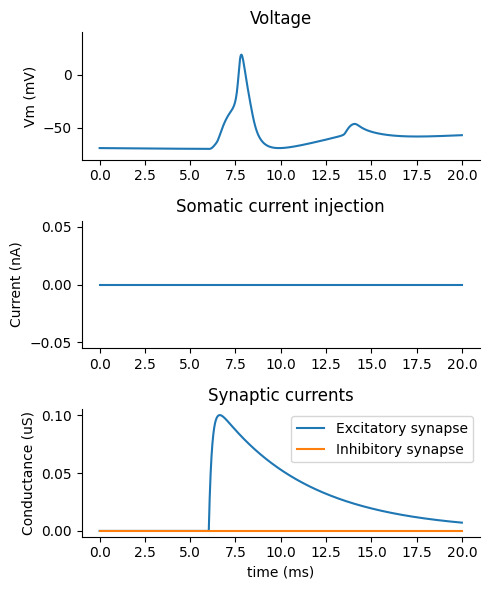

In [8]:
# many neurons firing at once or can be one neuron but multiple receptors (10 x synchronous activation)
nc_estim.weight[0] = 0.1 # excitatory stimulus 
nc_istim.weight[0] = 0 # inhibitory stimulus 
iclamp.amp=0 # no current injection to the soma 
h.run() # run simulation 

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(311) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
# Uncomment to plot other voltages
# ax0.plot(t_vec,cell.ais_v,label='Distal AIS')
# ax0.plot(t_vec,cell.dend0_vs[xind(dend0_x_vals,0.5)],label='dend[0](0.5)')
# ax0.plot(t_vec,cell.dend1_vs[xind(dend1_x_vals,0.5)],label='dend[1](0.5)',ls='--')
# ax0.legend()
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax1 = fig.add_subplot(312) # injected current
ax1.plot(t_vec,iclamp_i)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Somatic current injection')
ax2 = fig.add_subplot(313)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()

Change the voltage of the current applied at the soma, the same result. 

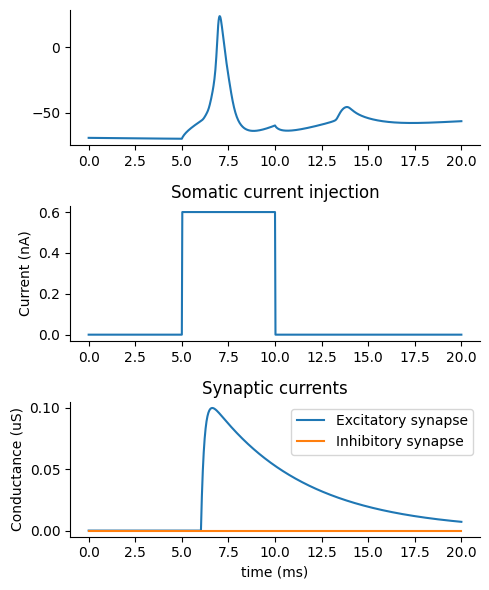

In [9]:
# many neurons firing at once or can be one neuron but multiple receptors (10 x synchronous activation)
nc_estim.weight[0] = 0.1 # excitatory stimulus 
nc_istim.weight[0] = 0 # inhibitory stimulus 
iclamp.amp=0.6 # current injection to the soma 
h.run() # run simulation 

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(311) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')

# Uncomment to plot other voltages
# ax0.plot(t_vec,cell.ais_v,label='Distal AIS')
# ax0.plot(t_vec,cell.dend0_vs[xind(dend0_x_vals,0.5)],label='dend[0](0.5)') # at the first segment on the dendrite 
# ax0.plot(t_vec,cell.dend1_vs[xind(dend1_x_vals,0.5)],label='dend[1](0.5)',ls='--') # at the second segment on the dendrite 
# ax0.legend()
# ax0.set_ylim(-80,40)
# ax0.set_ylabel('Vm (mV)')
# ax0.set_title('Voltage')

ax1 = fig.add_subplot(312) # injected current
ax1.plot(t_vec,iclamp_i)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Somatic current injection')

ax2 = fig.add_subplot(313)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')

# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')

ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()

When you change the weights, there is more conductance of ions, but still the same number of APs being generated. 

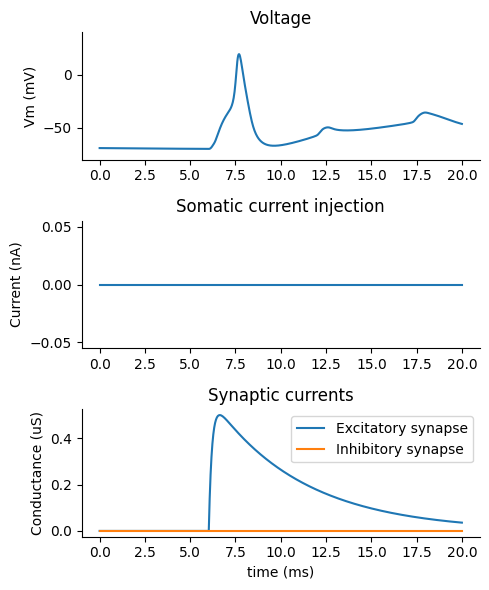

In [10]:
nc_estim.weight[0] = 0.5 # many neurons firing at once or can be one neuron but multiple receptors (10 x synchronous activation)
nc_istim.weight[0] = 0
iclamp.amp=0
h.run()

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(311) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax1 = fig.add_subplot(312) # injected current
ax1.plot(t_vec,iclamp_i)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Somatic current injection')
ax2 = fig.add_subplot(313)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()

If there is an excitatory stimulus at the synapse, an EPSP will always occur before an IPSP. 

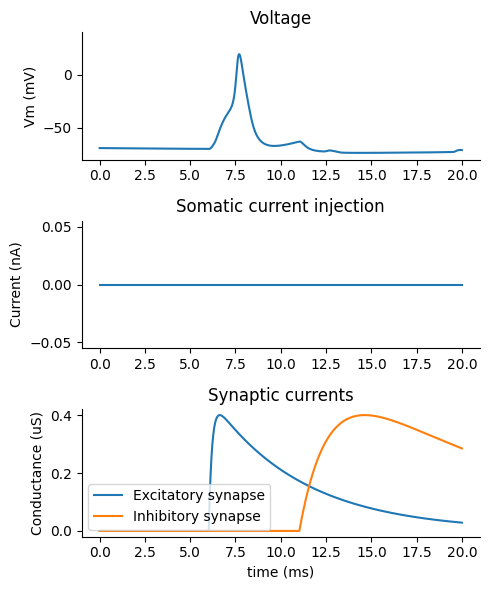

In [11]:
nc_estim.weight[0] = 0.4 # many neurons firing at once or can be one neuron but multiple receptors (10 x synchronous activation)
nc_istim.weight[0] = 0.4
iclamp.amp=0
h.run()

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(311) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax1 = fig.add_subplot(312) # injected current
ax1.plot(t_vec,iclamp_i)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Somatic current injection')
ax2 = fig.add_subplot(313)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()

Change the location of the synapse. 

Difference between when the AIS is on the soma, and when it is on the dendrite.

In [ ]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.8 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
exc_syn = h.Exp2Syn(cell.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # rise time - taken from Hodapp 2022 supp materials
exc_syn.tau2 = 5 # decay time
exc_syn.e = 0 # reversal (more permeable to sodium than potassium)

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell.soma(0.5))
inh_syn.tau1 = 1.6
inh_syn.tau2 = 11
inh_syn.e = -75 # negative in - hyperpolarizes cell (GABA's ions)

Somatic excitatory input and dendritic inhibitory input 

Conclusion: a neuron with an axon-carrying dendrite is more easily activated than a neuron with an axon emerging from the soma

 How does threshold for firing with somatic current injection or synchronous AMPA synaptic activation at single location differ between neuron with axon-carrying dendrite vs. axon of somatic origin? 
 
 
 Apply currents or excitatory synaptic inputs across a range of intensities for both models and compare the number of APs vs. input strength. 
 
 For current amplitude, this is the frequency-input curve we’ve generated in several exercises.
